In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from compressai.entropy_models import EntropyBottleneck
from compressai.layers import GDN
from compressai.models import CompressionModel
from compressai.models.utils import conv, deconv

In [3]:
import PIL.Image as Image
def pil_to_pt(img):
    t = transforms.functional.pil_to_tensor(img)
    t = t.to(torch.float)
    t = t/255
    t = t-0.5
    t = t.unsqueeze(0)
    return t

In [4]:
def pt_to_pil(t):
    t = t+0.5
    t = t*255
    t = torch.clamp(t, min=-0.49, max=255.49)
    t = t.round()
    t = t.to(torch.uint8)
    return t

In [5]:
class Network(CompressionModel):
    def __init__(self, N=128):
        super().__init__()
        self.entropy_bottleneck = EntropyBottleneck(N)
        self.encode = nn.Sequential(
            conv(3, N),
            GDN(N),
            conv(N, N),
            GDN(N),
            conv(N, N),
        )

        self.decode = nn.Sequential(
            deconv(N, N),
            GDN(N, inverse=True),
            deconv(N, N),
            GDN(N, inverse=True),
            deconv(N, 3),
        )

    def forward(self, x):
        y = self.encode(x)
        y_hat, y_likelihoods = self.entropy_bottleneck(y)
        x_hat = self.decode(y_hat)
        return x_hat, y_likelihoods

In [6]:
net = Network()
net = net.to("cuda")
checkpoint = torch.load("checkpoint.pth")
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

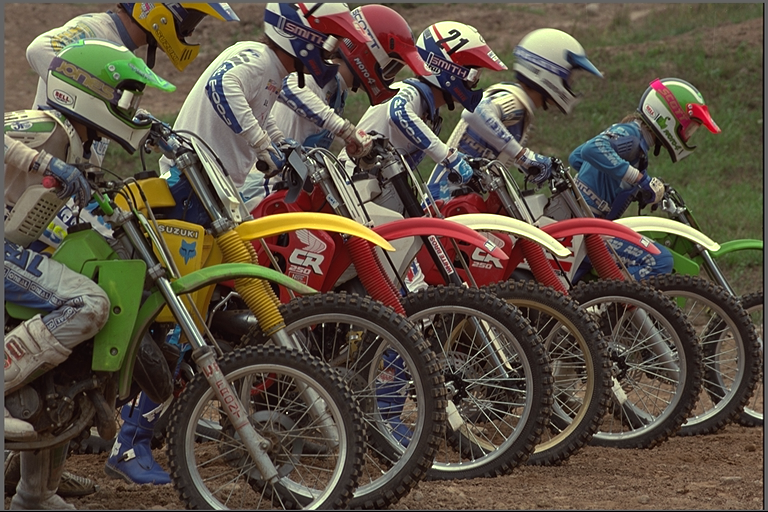

In [7]:
img = Image.open("kodim05.png");
t = pil_to_pt(img)
img

In [10]:
z = net.encode(t.to("cuda"))
x = net.decode(z)
x̂ = net.decode(z.round())
y = pt_to_pil(x.detach().to("cpu"))
ŷ = pt_to_pil(x̂.detach().to("cpu"))

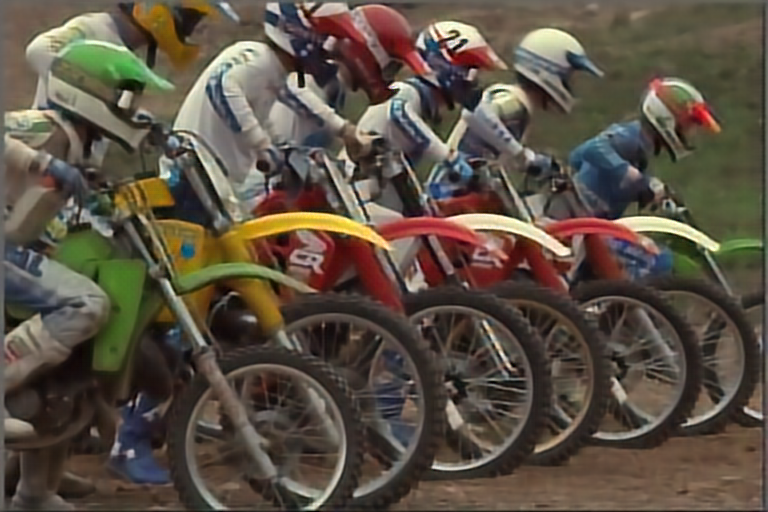

In [11]:
transforms.ToPILImage()(y[0])

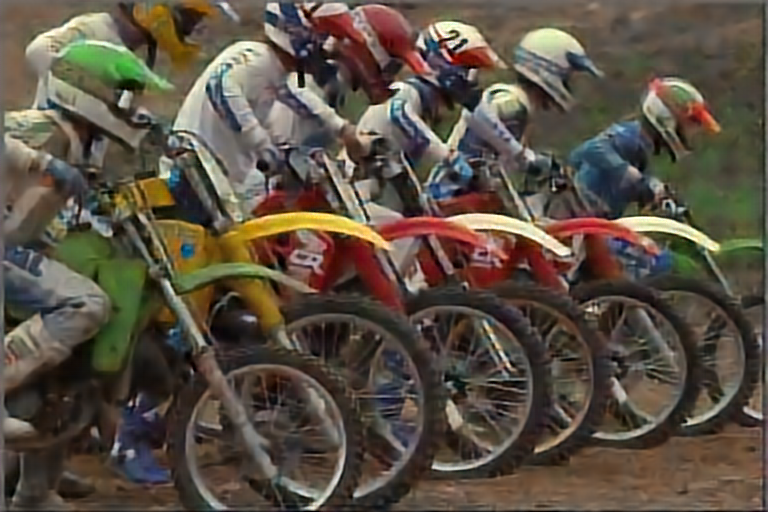

In [12]:
transforms.ToPILImage()(ŷ[0])